In [1]:
import os
import csv
import pandas as pd
import numpy as np

In [2]:
dataset_names=[]
X_trains=[]
y_trains=[]
X_tests=[]

path = "C:/Users/KuanYi/Downloads/DataScienceCP1_lys_branch/Competition_data"
for folder_name in os.listdir(path):
    print(folder_name)
    dataset_names.append(folder_name)
    X_trains.append(pd.read_csv(f"{path}/{folder_name}/X_train.csv", header=0))
    y_trains.append(pd.read_csv(f"{path}/{folder_name}/y_train.csv", header=0))
    X_tests.append(pd.read_csv(f"{path}/{folder_name}/X_test.csv", header=0))

Dataset_1
Dataset_10
Dataset_11
Dataset_12
Dataset_13
Dataset_14
Dataset_15
Dataset_16
Dataset_17
Dataset_18
Dataset_19
Dataset_2
Dataset_20
Dataset_21
Dataset_22
Dataset_23
Dataset_24
Dataset_25
Dataset_26
Dataset_27
Dataset_28
Dataset_29
Dataset_3
Dataset_30
Dataset_31
Dataset_32
Dataset_33
Dataset_34
Dataset_35
Dataset_36
Dataset_37
Dataset_38
Dataset_39
Dataset_4
Dataset_40
Dataset_41
Dataset_42
Dataset_43
Dataset_44
Dataset_45
Dataset_46
Dataset_47
Dataset_48
Dataset_49
Dataset_5
Dataset_6
Dataset_7
Dataset_8
Dataset_9


In [3]:
## Train & Test & Split & Build Model
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

>> Preprocessing functions

In [4]:
import numpy as np
import pandas as pd

def remove_outlier(df, lower_quantile=0.25, upper_quantile=0.75, iqr_multiplier=1.5):
    """
    去除數值型特徵中的異常值（基於 IQR）。
    """
    numeric_cols = df.select_dtypes(include=['float64', 'int64'])
    for col in numeric_cols.columns:
        Q1 = df[col].quantile(lower_quantile)
        Q3 = df[col].quantile(upper_quantile)
        IQR = Q3 - Q1
        lower_bound = Q1 - iqr_multiplier * IQR
        upper_bound = Q3 + iqr_multiplier * IQR
        df[col] = np.clip(df[col], lower_bound, upper_bound)  # 將異常值剪裁到合理範圍
    return df

from sklearn.feature_selection import VarianceThreshold

def remove_low_variance(df, threshold=0.0001):
    """
    移除方差低於 threshold 的特徵。
    """
    selector = VarianceThreshold(threshold=threshold)
    numeric_data = df.select_dtypes(include=['float64', 'int64'])
    high_variance_data = selector.fit_transform(numeric_data)
    retained_features = numeric_data.columns[selector.get_support()]
    df = df[retained_features]
    return df

from scipy.stats import boxcox

def adjust_skewness(df, skew_threshold=2):
    """
    調整偏態，對偏度高於指定閾值的數值型特徵進行處理。
    """
    numeric_cols = df.select_dtypes(include=['float64', 'int64'])
    for col in numeric_cols.columns:
        skewness = df[col].skew()
        if skewness > skew_threshold:  # 偏態較高
            if (df[col] > 0).all():  # Box-Cox 要求數據為正數
                df[col], _ = boxcox(df[col] + 1e-6)
            else:  # 含有非正數，則使用 log1p
                df[col] = np.log1p(df[col] - df[col].min() + 1e-6)
    return df

from catboost import CatBoostClassifier

def select_important_features(X, y, importance_threshold=0.005, retained_top_fraction=0.8):
    """
    基於 CatBoost 的特徵重要性，選擇相關特徵。
    """
    # 確保 X 是 DataFrame 格式
    if isinstance(X, np.ndarray):
        X = pd.DataFrame(X)

    # 定義 CatBoost 模型
    model = CatBoostClassifier(
        iterations=100,           # 訓練輪數（適合快速計算重要性）
        learning_rate=0.05,       # 學習率
        depth=6,                  # 樹的深度
        eval_metric='AUC',        # 評估指標
        random_seed=123,          # 固定隨機種子
        verbose=0                 # 關閉訓練輸出
    )

    # 訓練模型
    model.fit(X, y)

    # 獲取特徵重要性
    feature_importances = pd.Series(
        model.get_feature_importance(),
        index=X.columns
    ).sort_values(ascending=False)

    # 根據 importance_threshold 選擇初步篩選的特徵
    selected_features = feature_importances[feature_importances > importance_threshold].index.tolist()

    # 檢查篩選後的特徵數量
    if len(selected_features) < int(len(feature_importances) * retained_top_fraction):
        # 如果刪除的特徵過多，保留重要性最高的特徵
        num_to_retain = int(len(feature_importances) * retained_top_fraction)
        top_features = feature_importances.nlargest(num_to_retain).index.tolist()
        selected_features = list(set(selected_features + top_features))  # 合併去重
        print(f"Retained top {retained_top_fraction*100:.0f}% of features based on importance.")

    # 選擇重要特徵
    X_selected = X[selected_features]

    print(f"Selected {len(selected_features)} important features out of {X.shape[1]}. "
          f"(retained_top_fraction={retained_top_fraction}, importance_threshold={importance_threshold})")

    return X_selected, selected_features



from imblearn.over_sampling import SMOTE, ADASYN

def handle_class_imbalance(X, y, method='smote'):
    """
    使用 SMOTE 或 ADASYN 處理類別不平衡。
    """
    if method == 'smote':
        sampler = SMOTE(random_state=42)
    elif method == 'adasyn':
        sampler = ADASYN(random_state=42)
    else:
        raise ValueError(f"Unsupported imbalance method: {method}")
    
    X_resampled, y_resampled = sampler.fit_resample(X, y)
    print(f"Class imbalance handled: {dict(pd.Series(y_resampled).value_counts())}")
    return X_resampled, y_resampled


>> Pipeline

In [5]:
def preprocess_pipeline(X, y=None, imbalance_method='smote', selected_features=None, encoder=None):
    """
    預處理流水線：分離數值和類別特徵，進行數據清理、特徵選擇以及類別不平衡處理。
    """
    print("Starting preprocessing pipeline...")

    # 分離數值型和類別型特徵
    numeric_features = X.select_dtypes(include=['float64', 'int64'])
    categorical_features = X.select_dtypes(include=['object', 'category'])

    # 測試階段
    if y is None:
        print("Testing stage: Applying pre-selected features and encoder...")

        # 驗證必要參數
        if selected_features is None:
            raise ValueError("Testing stage requires selected_features.")
        if categorical_features.shape[1] > 0 and encoder is None:
            raise ValueError("Testing stage requires encoder when categorical features are present.")

        # 處理類別型特徵（如果存在）
        if categorical_features.shape[1] > 0:
            if encoder is None:
                raise ValueError("Encoder is None during testing stage, but categorical features are present.")
            X_categorical = encoder.transform(categorical_features)
        else:
            X_categorical = np.empty((X.shape[0], 0))  # 空數組

        # 數值型特徵
        X_numeric = numeric_features.values  # 轉換為 NumPy

        # 合併數值型和類別型特徵
        X_combined = np.hstack([X_numeric, X_categorical])

        # 應用選擇的特徵
        if isinstance(selected_features[0], str):  # 如果選擇的特徵是列名
            all_feature_names = list(numeric_features.columns)
            if categorical_features.shape[1] > 0:
                all_feature_names += encoder.get_feature_names_out(categorical_features.columns).tolist()
            feature_indices = [all_feature_names.index(feat) for feat in selected_features]
            X_combined = X_combined[:, feature_indices]
        else:  # 如果選擇的特徵是索引
            X_combined = X_combined[:, selected_features]

        print(f"Testing stage: Final dataset shape after applying selected features: {X_combined.shape}")
        return X_combined, None, selected_features, encoder


    # 訓練階段執行完整預處理
    print("Training stage: Performing full preprocessing...")

    # Step 1: Process numeric features
    X_numeric = numeric_features.copy()
    X_numeric = remove_outlier(X_numeric)
    X_numeric = remove_low_variance(X_numeric)
    X_numeric = adjust_skewness(X_numeric)

    # Step 2: Process categorical features (One-hot encoding)
    if categorical_features.shape[1] > 0:
        encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
        X_categorical = encoder.fit_transform(categorical_features)
        categorical_feature_names = encoder.get_feature_names_out(categorical_features.columns)
    else:
        encoder = None
        X_categorical = np.empty((X_numeric.shape[0], 0))  # 空數組
        categorical_feature_names = []

    # Combine numeric and categorical features
    X_combined = np.hstack([X_numeric, X_categorical])
    all_feature_names = list(X_numeric.columns) + list(categorical_feature_names)

    # 修正特徵名稱長度
    if len(all_feature_names) > X_combined.shape[1]:
        all_feature_names = all_feature_names[:X_combined.shape[1]]

    X_combined = pd.DataFrame(X_combined, columns=all_feature_names)
    print(f"Combined dataset shape: {X_combined.shape}")

    # Step 3: Select important features
    X_combined, selected_features = select_important_features(X_combined, y)
    print(f"Selected features: {selected_features}")

    # Step 4: Handle class imbalance
    X_final, y_final = handle_class_imbalance(X_combined, y, method=imbalance_method)

    # 確保數據格式一致
    if isinstance(X_final, np.ndarray):
        X_final = pd.DataFrame(X_final, columns=selected_features)

    print(f"Final dataset shape: {X_final.shape}")
    print("Preprocessing pipeline completed.")
    return X_final, y_final, selected_features, encoder


In [12]:
#raw
average_raw_auc = 0  # 新增變數來記錄 raw AUC
average_processed_auc = 0  # 保留處理後的 AUC 計算
y_predicts = []

for i in range(len(dataset_names)):

    # Get features and labels for the current dataset
    X_sample = X_trains[i]  # Keep as pandas DataFrame
    y_sample = y_trains[i].values.ravel()
    X_test = X_tests[i]  # Test data

    # === Raw AUC ===
    # Train-test split for raw data
    X_train_raw, X_val_raw, y_train_raw, y_val_raw = train_test_split(X_sample, y_sample, train_size=0.6, random_state=123)

    # 定義模型
    model_raw = CatBoostClassifier(
        iterations=500,
        learning_rate=0.05,
        depth=6,
        eval_metric='AUC',
        random_seed=123,
        verbose=0
    )

    # Train and validate on raw data
    model_raw.fit(X_train_raw, y_train_raw)
    y_val_proba_raw = model_raw.predict_proba(X_val_raw)[:, 1]
    auc_raw = roc_auc_score(y_val_raw, y_val_proba_raw)
    average_raw_auc += auc_raw

    print(f"Dataset {dataset_names[i]} Raw Validation AUC: {auc_raw:.4f}")

    # === Preprocessed Data AUC ===
    # Data preprocessing, perform feature selection during training
    X_sample_processed, y_sample_processed, selected_features, encoder = preprocess_pipeline(
        X_sample,
        y_sample,
        imbalance_method='smote'
    )

    # Preprocess test data, ensuring synchronization with training phase
    X_test_processed, _, _, _ = preprocess_pipeline(
        X_test,
        selected_features=selected_features,  # Use selected features
        encoder=encoder,  # Use encoder from training phase
    )

    # Convert test data back to DataFrame with feature names
    X_test_processed = pd.DataFrame(X_test_processed, columns=selected_features)

    # Train-test split
    X_train, X_val, y_train, y_val = train_test_split(X_sample_processed, y_sample_processed, train_size=0.6, random_state=123)

    # 定義模型
    model_processed = CatBoostClassifier(
        iterations=500,
        learning_rate=0.05,
        depth=6,
        eval_metric='AUC',
        random_seed=123,
        verbose=0
    )

    model_processed.fit(X_train, y_train)
    
    # Validation set prediction
    y_val_proba_processed = model_processed.predict_proba(X_val)[:, 1]
    auc_processed = roc_auc_score(y_val, y_val_proba_processed)
    average_processed_auc += auc_processed

    print(f"Dataset {dataset_names[i]} Preprocessed Validation AUC: {auc_processed:.4f}")

    # Generate prediction probabilities for the test set
    y_test_proba = model_processed.predict_proba(X_test_processed)[:, 1]
    y_predicts.append(pd.DataFrame(y_test_proba, columns=['y_predict_proba']))

    # Save to the corresponding path
    output_dir = os.path.join(path, dataset_names[i])  # Generate path based on root path and dataset name
    os.makedirs(output_dir, exist_ok=True)
    y_predicts[-1].to_csv(os.path.join(output_dir, "y_predict.csv"), index=False)

# Average AUC across datasets
average_raw_auc /= len(dataset_names)
average_processed_auc /= len(dataset_names)

print(f"Average Raw AUC = {average_raw_auc:.4f}")
print(f"Average Processed AUC = {average_processed_auc:.4f}")


Dataset Dataset_1 Raw Validation AUC: 0.8448
Starting preprocessing pipeline...
Training stage: Performing full preprocessing...
Combined dataset shape: (444, 17)
Selected 17 important features out of 17. (retained_top_fraction=0.8, importance_threshold=0.005)
Selected features: ['Feature_1', 'Feature_2', 'Feature_12', 'Feature_4', 'Feature_11', 'Feature_13', 'Feature_17', 'Feature_20', 'Feature_9', 'Feature_8', 'Feature_16', 'Feature_10', 'Feature_19', 'Feature_3', 'Feature_5', 'Feature_6', 'Feature_7']
Class imbalance handled: {0: 313, 1: 313}
Final dataset shape: (626, 17)
Preprocessing pipeline completed.
Starting preprocessing pipeline...
Testing stage: Applying pre-selected features and encoder...
Testing stage: Final dataset shape after applying selected features: (296, 17)
Dataset Dataset_1 Preprocessed Validation AUC: 0.9295
Dataset Dataset_10 Raw Validation AUC: 0.7729
Starting preprocessing pipeline...
Training stage: Performing full preprocessing...
Combined dataset shape: 

In [11]:
#processed
average_auc = 0
y_predicts = []

for i in range(len(dataset_names)):

    # Get features and labels for the current dataset
    X_sample = X_trains[i]  # Keep as pandas DataFrame
    y_sample = y_trains[i].values.ravel()
    X_test = X_tests[i]  # Test data
    
    # Data preprocessing, perform feature selection during training
    X_sample, y_sample, selected_features, encoder = preprocess_pipeline(
        X_sample,
        y_sample,
        imbalance_method='smote'
    )

    # Preprocess test data, ensuring synchronization with training phase
    X_test_processed, _, _, _ = preprocess_pipeline(
        X_test,
        selected_features=selected_features,  # Use selected features
        encoder=encoder,  # Use encoder from training phase
    )

    # Convert test data back to DataFrame with feature names
    X_test_processed = pd.DataFrame(X_test_processed, columns=selected_features)
    
    # Train-test split
    X_train, X_val, y_train, y_val = train_test_split(X_sample, y_sample, train_size=0.6, random_state=123)

    # 定義模型
    model = CatBoostClassifier(
    iterations=500,              # 迭代次數
    learning_rate=0.05,          # 學習率
    depth=6,                     # 每棵樹的深度
    eval_metric='AUC',           # 評估指標
    random_seed=123,             # 固定隨機種子
    verbose=0                    # 關閉訓練輸出
    )

    model.fit(X_train, y_train)
    
    # Validation set prediction
    y_val_proba = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_val_proba)
    average_auc += auc

    print(f"Dataset {dataset_names[i]} Validation AUC: {auc:.4f}")

    # Generate prediction probabilities for the test set
    y_test_proba = model.predict_proba(X_test_processed)[:, 1]
    y_predicts.append(pd.DataFrame(y_test_proba, columns=['y_predict_proba']))

    # Save to the corresponding path
    output_dir = os.path.join(path, dataset_names[i])  # Generate path based on root path and dataset name
    os.makedirs(output_dir, exist_ok=True)
    y_predicts[-1].to_csv(os.path.join(output_dir, "y_predict.csv"), index=False)

# Average AUC across datasets
average_auc /= len(dataset_names)
print(f"Average AUC = {average_auc:.4f}")


Starting preprocessing pipeline...
Training stage: Performing full preprocessing...
Combined dataset shape: (444, 17)
Selected 17 important features out of 17. (retained_top_fraction=0.8, importance_threshold=0.005)
Selected features: ['Feature_1', 'Feature_2', 'Feature_12', 'Feature_4', 'Feature_11', 'Feature_13', 'Feature_17', 'Feature_20', 'Feature_9', 'Feature_8', 'Feature_16', 'Feature_10', 'Feature_19', 'Feature_3', 'Feature_5', 'Feature_6', 'Feature_7']
Class imbalance handled: {0: 313, 1: 313}
Final dataset shape: (626, 17)
Preprocessing pipeline completed.
Starting preprocessing pipeline...
Testing stage: Applying pre-selected features and encoder...
Testing stage: Final dataset shape after applying selected features: (296, 17)
Dataset Dataset_1 Validation AUC: 0.9295
Starting preprocessing pipeline...
Training stage: Performing full preprocessing...
Combined dataset shape: (467, 9)
Selected 9 important features out of 9. (retained_top_fraction=0.8, importance_threshold=0.005)

>> Second

In [7]:
average_auc = 0
y_predicts = []

for i in range(len(dataset_names)):

    # 獲取當前數據集的特徵和標籤
    X_sample = X_trains[i]
    y_sample = y_trains[i].values.ravel()
    X_test = X_tests[i]

    # 確保數據格式一致
    if not isinstance(X_sample, pd.DataFrame):
        X_sample = pd.DataFrame(X_sample)
    if not isinstance(X_test, pd.DataFrame):
        X_test = pd.DataFrame(X_test)

    # 定義模型
    model = CatBoostClassifier(
    iterations=500,              # 迭代次數
    learning_rate=0.05,          # 學習率
    depth=6,                     # 每棵樹的深度
    eval_metric='AUC',           # 評估指標
    random_seed=123,             # 固定隨機種子
    verbose=0                    # 關閉訓練輸出
    )

    # Step 1: 測試未經預處理的性能
    X_train, X_val, y_train, y_val = train_test_split(X_sample, y_sample, train_size=0.6, random_state=123)
    model.fit(X_train, y_train)
    y_val_proba_raw = model.predict_proba(X_val)[:, 1]
    auc_raw = roc_auc_score(y_val, y_val_proba_raw)

    print(f"Dataset {dataset_names[i]} Raw Validation AUC: {auc_raw:.4f}")

    # 如果未經預處理的 AUC 已經達到 1.0，則跳過預處理
    if auc_raw >= 1.0:
        print(f"Dataset {dataset_names[i]} reached perfect AUC without preprocessing. Skipping preprocessing.")
        X_test_processed = X_test
    else:
        # Step 2: 預處理數據
        X_sample_preprocessed, y_sample_preprocessed, selected_features, encoder = preprocess_pipeline(
            X_sample,
            y_sample,
            imbalance_method='smote'
        )

        # 預處理測試數據
        X_test_processed, _, _, _ = preprocess_pipeline(
            X_test,
            selected_features=selected_features,
            encoder=encoder,
        )

        # 修正測試數據列名，確保與訓練數據一致
        X_test_processed = pd.DataFrame(X_test_processed, columns=X_sample_preprocessed.columns)

        # Step 3: 測試經過預處理的性能
        X_train_preprocessed, X_val_preprocessed, y_train_preprocessed, y_val_preprocessed = train_test_split(
            X_sample_preprocessed, y_sample_preprocessed, train_size=0.6, random_state=123
        )
        model.fit(X_train_preprocessed, y_train_preprocessed)
        y_val_proba_preprocessed = model.predict_proba(X_val_preprocessed)[:, 1]
        auc_preprocessed = roc_auc_score(y_val_preprocessed, y_val_proba_preprocessed)

        print(f"Dataset {dataset_names[i]} Preprocessed Validation AUC: {auc_preprocessed:.4f}")

        # 選擇較高性能的數據集
        if auc_preprocessed > auc_raw:
            print(f"Using preprocessed data for Dataset {dataset_names[i]}.")
            X_sample, y_sample = X_sample_preprocessed, y_sample_preprocessed
        else:
            print(f"Using raw data for Dataset {dataset_names[i]}.")
            X_test_processed = X_test  # 如果原始數據表現更好

    # Step 4: 最終模型訓練和測試
    model.fit(X_sample, y_sample)

    # 修正測試數據列名
    X_test_processed = pd.DataFrame(X_test_processed, columns=X_sample.columns)

    y_test_proba = model.predict_proba(X_test_processed)[:, 1]
    y_predicts.append(pd.DataFrame(y_test_proba, columns=['y_predict_proba']))

    # 保存到對應路徑
    output_dir = os.path.join(path, dataset_names[i])
    os.makedirs(output_dir, exist_ok=True)
    y_predicts[-1].to_csv(os.path.join(output_dir, "y_predict.csv"), index=False)

    # 更新 AUC 統計
    auc_preprocessed = locals().get('auc_preprocessed', -1)
    average_auc += max(auc_raw, auc_preprocessed) if auc_preprocessed != -1 else auc_raw

# Average AUC across datasets
average_auc /= len(dataset_names)
print(f"Average AUC = {average_auc:.4f}")


Dataset Dataset_1 Raw Validation AUC: 0.8448
Starting preprocessing pipeline...
Training stage: Performing full preprocessing...
Combined dataset shape: (444, 17)
Selected 17 important features out of 17. (retained_top_fraction=0.8, importance_threshold=0.005)
Selected features: ['Feature_1', 'Feature_2', 'Feature_12', 'Feature_4', 'Feature_11', 'Feature_13', 'Feature_17', 'Feature_20', 'Feature_9', 'Feature_8', 'Feature_16', 'Feature_10', 'Feature_19', 'Feature_3', 'Feature_5', 'Feature_6', 'Feature_7']
Class imbalance handled: {0: 313, 1: 313}
Final dataset shape: (626, 17)
Preprocessing pipeline completed.
Starting preprocessing pipeline...
Testing stage: Applying pre-selected features and encoder...
Testing stage: Final dataset shape after applying selected features: (296, 17)
Dataset Dataset_1 Preprocessed Validation AUC: 0.9295
Using preprocessed data for Dataset Dataset_1.
Dataset Dataset_10 Raw Validation AUC: 0.7729
Starting preprocessing pipeline...
Training stage: Performing

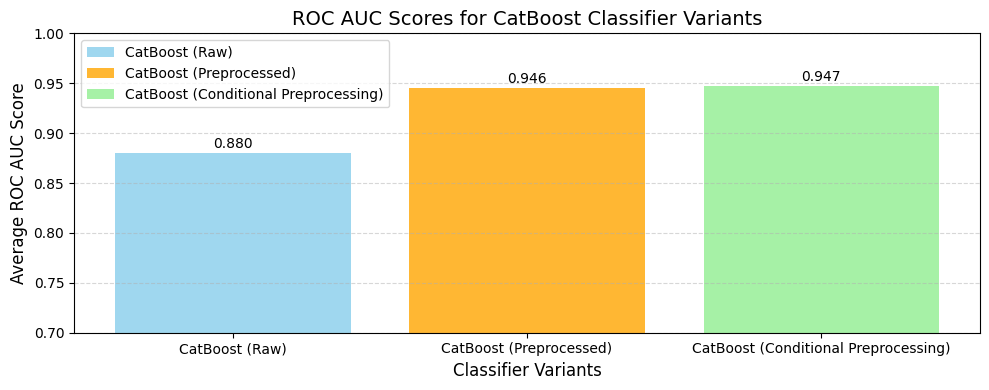

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# AUC_set values
AUC_set = [
    np.float64(0.8805),
    np.float64(0.9455),
    np.float64(0.9472),
]

classifiers = [
    "CatBoost (Raw)",
    "CatBoost (Preprocessed)",
    "CatBoost (Conditional Preprocessing)"
]

# Define different colors for each bar
colors = ['skyblue', 'orange', 'lightgreen']

# Plotting the bar graph
plt.figure(figsize=(10, 4))
bars = plt.bar(classifiers, AUC_set, color=colors, alpha=0.8)

# Annotate data points with their corresponding AUC values
for bar, value in zip(bars, AUC_set):
    plt.text(bar.get_x() + bar.get_width() / 2, value + 0.005, f"{value:.3f}",
             ha='center', fontsize=10)  # Display AUC values above the bars

# Add a custom legend
plt.legend(bars, classifiers, fontsize=10, loc='upper left')

plt.title('ROC AUC Scores for CatBoost Classifier Variants', fontsize=14)
plt.xlabel('Classifier Variants', fontsize=12)
plt.ylabel('Average ROC AUC Score', fontsize=12)
plt.ylim(0.7, 1.00)  # Set Y-axis limits
plt.grid(visible=True, linestyle='--', alpha=0.5, axis='y')  # Add horizontal gridlines

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()